Reproducing the solution for linear regression proposed in [vector quantile regression: an optimal transport approach](https://arxiv.org/pdf/1406.4643). There is no code provided for this article.

In [1]:
import numpy as np
from scipy.optimize import linprog

def solve_vqr_primal(Y, X, U, nu, mu):
    """
    Solves the primal form of the Vector Quantile Regression (VQR) linear program.

    This function implements the discrete formulation of the VQR problem as
    described in equation (4.1) of "VECTOR QUANTILE REGRESSION" by
    G. Carlier, V. Chernozhukov, and A. Galichon.

    Args:
        Y (np.ndarray): The n x q matrix of response variables.
        X (np.ndarray): The n x p matrix of regressors.
        U (np.ndarray): The m x q matrix of points for the reference distribution.
        nu (np.ndarray): The n x 1 vector of probability weights for observations (Y, X).
        mu (np.ndarray): The m x 1 vector of probability weights for the reference points U.

    Returns:
        scipy.optimize.OptimizeResult: The result object from scipy.optimize.linprog.
        The optimal `pi` matrix can be recovered by `res.x.reshape((n, m)).T`.
    """
    n, _ = Y.shape
    m, _ = U.shape

    UY_transpose = U @ Y.T
    c = -UY_transpose.flatten('F')

    # Constraint (a): Marginal distribution of (X, Y) is nu.
    A_eq_a = np.kron(np.eye(n), np.ones((1, m)))

    E_X = nu.T @ X
    mu_EX = mu @ E_X

    A_eq_b = np.kron(X.T, np.eye(m))
    b_eq_b = mu_EX.flatten('F')

    A_eq = np.vstack([A_eq_a, A_eq_b])
    b_eq = np.concatenate([nu.flatten(), b_eq_b])

    bounds = (0, None)

    print("Solving the linear program...")
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    return res

Sampling has to be from the grid, otherwise we can not compute the derivative

In [ ]:
from data_utils import create_joint_x_y


num_points_to_generate = 500
num_latent_points_to_generate = 500

X, Y = create_joint_x_y(num_points_to_generate)
X = np.concatenate([X, np.ones((num_points_to_generate, 1))], axis=1)

n, d = Y.shape
U = np.random.normal(size=(num_latent_points_to_generate, d))
m = U.shape[0]

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

result = solve_vqr_primal(Y, X, U, nu, mu)

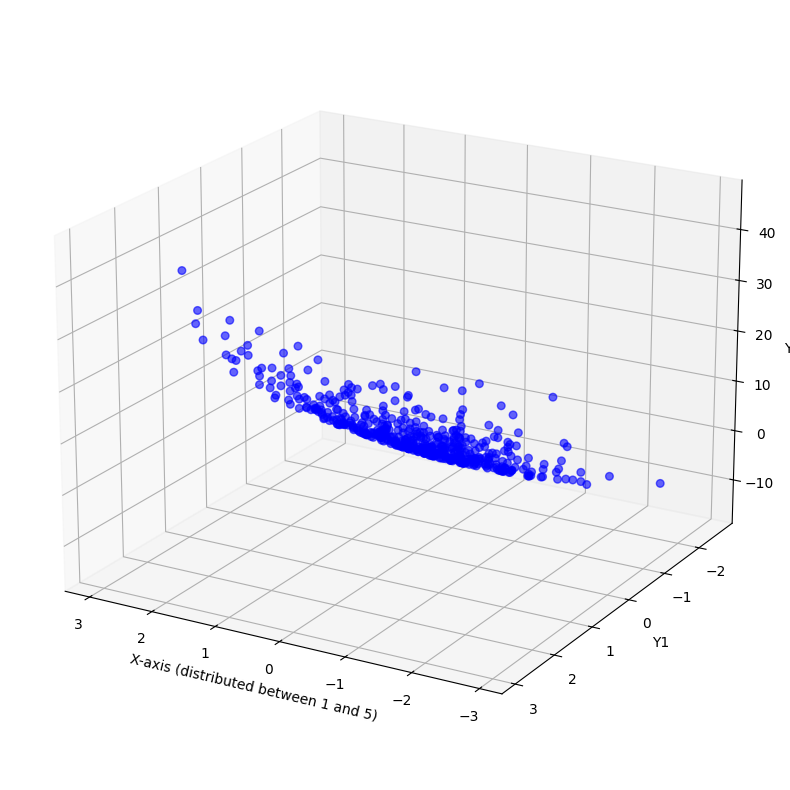

In [ ]:
import matplotlib.pyplot as plt

# Change to %matplotlib qt to have interactive plots
%matplotlib inline

x = X[0, :]
b_u = result.eqlin['marginals'][num_points_to_generate:].reshape((U.shape[0], X.shape[1]), order='F')
phi_dual_potential = - b_u @ x

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(U[:,0 ], U[:, 1], phi_dual_potential, c='blue', marker='o', s=30, alpha=0.6)

ax.set_xlabel('X-axis (distributed between 1 and 5)')
ax.set_ylabel('Y1')
ax.set_zlabel('Y2')

ax.grid(True)
ax.view_init(elev=20, azim=120)

plt.show()

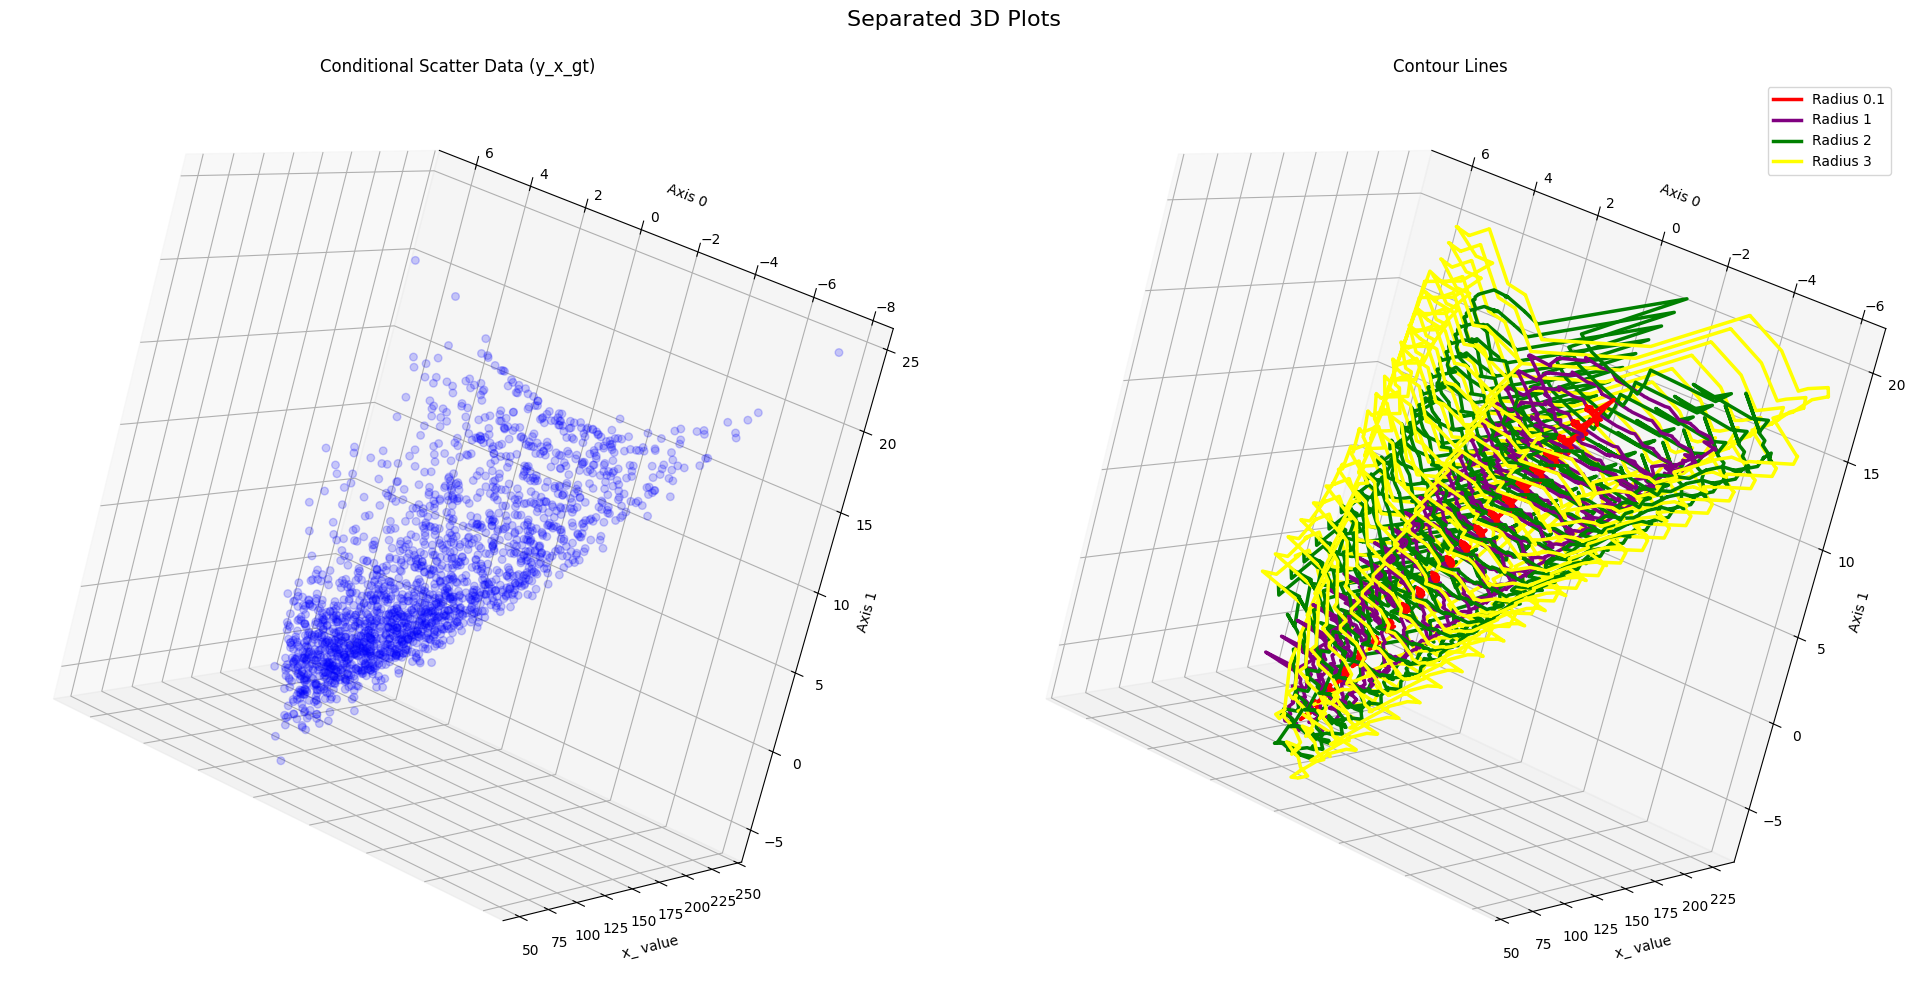

In [ ]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline

from data_utils import create_conditional_x
from jaccobian_utils import estimate_gradients_for_points_knn

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)


ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100, 1])

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x[0])
    z_scatter = np.full(y_x_gt.shape[0], x_)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):
    x = np.array([x_ / 100, 1])

    colors = ['red', 'purple', 'green', 'yellow']
    radii = [0.1, 1, 2, 3]

    for contour_radius, color in zip(radii, colors):
        pi = np.linspace(-np.pi, np.pi, 100) # Use linspace for a perfectly smooth circle

        u = np.stack([
            contour_radius * np.cos(pi),
            contour_radius * np.sin(pi),
        ])

        b_u = result['eqlin']['marginals'][num_points_to_generate:].reshape((U.shape[0], X.shape[1]), order='F')
        phi_u = -b_u @ x
        pushforward_of_u = estimate_gradients_for_points_knn(U, phi_u, points_of_interest=u.T, k=5)

        z_line = np.full(pushforward_of_u.shape[0], x_)

        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()